In [1]:
from typing import Callable, List
import numpy as np
import pandas as pd

import pyspark.sql
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark: SparkSession = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline  # type: ignore
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/11 00:59:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61228)
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/chaitanyasuma/Library/Python/3.9/lib/p

In [2]:
math_df: pyspark.sql.DataFrame = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
#portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

In [3]:
from pacdb import PACDataFrame, PACOptions, SamplerOptions

/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
df = math_df

query_name: str = "count"
budget_list: List[float] = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
sample_size: int = 3
sampling_rate: float = 0.5
m: int = 10
c: float = 1e-6
mi: float = 1./4

24/04/11 00:59:52 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
def query(df):
    return df.filter(df["absences"] >= 5).agg(F.count("*"))

pac_df = (PACDataFrame.fromDataFrame(df)
                    .withOptions(PACOptions(trials = m, max_mi = mi, c = c))
                    .withSamplerOptions(SamplerOptions(fraction=sampling_rate))
                    .withQuery(lambda x: query(x)))

pac_df.releaseValue()

Found output format of query: 


/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+
|count(1)|
+--------+
|     0.0|
+--------+

max_mi: 0.25, eta: 0.05, dimensions: 1
Hybrid Noise: Using the identity matrix as the projection matrix.


300it [00:25, 11.88it/s, loss=0.0309, target=0.05]
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Converged after 291 trials
Final variance estimates: [42.06605968280961]
sqrt total var is 6.485835311107553
Computed noise (variances) is [84.13211936561922]
Sample: [75] + Noise = Noised: [83.10347663770503]
Inserting to dataframe:
+-----------------+
|         count(1)|
+-----------------+
|83.10347663770503|
+-----------------+



DataFrame[count(1): double]

In [ ]:
def query(df):
    return df.groupBy(F.col("guardian")).agg(F.count("*"))

pac_df = (PACDataFrame.fromDataFrame(df)
                    .withOptions(PACOptions(trials = m, max_mi = mi, c = c))
                    .withSamplerOptions(SamplerOptions(fraction=sampling_rate))
                    .withQuery(lambda x: query(x)))

pac_df.releaseValue()

Found output format of query: 


/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(series.dtype):
/opt/homebrew/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+--------+
|guardian|count(1)|
+--------+--------+
|  father|     0.0|
|  mother|     0.0|
|   other|     0.0|
+--------+--------+

max_mi: 0.25, eta: 0.05, dimensions: 3
Using the identity matrix as the projection matrix.


0it [00:00, ?it/s]

Converged after 1301 trials
Final variance estimates: [21.487457469303163, 70.25039687439629, 7.937531645083514]
sqrt total var is 9.983756106234916
Computed noise (variances) is [92.55853536374374, 167.35872160506773, 56.25572079431135]
Sample: [ 49 136  17] + Noise: [92.55853536374374, 167.35872160506773, 56.25572079431135] = Noised: [48.825404333419996, 100.16134904466116, 19.554682773846373]


/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(series.dtype):
/opt/homebrew/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Inserting to dataframe:
+--------+------------------+
|guardian|          count(1)|
+--------+------------------+
|  father|48.825404333419996|
|  mother|100.16134904466116|
|   other|19.554682773846373|
+--------+------------------+



DataFrame[guardian: string, count(1): double]

In [9]:
query(df).show()

+--------+--------+
|guardian|count(1)|
+--------+--------+
|  father|      90|
|  mother|     273|
|   other|      32|
+--------+--------+



In [5]:
def query(df):
    return df.groupBy(F.col("guardian")).agg(F.avg("absences"), F.max("absences"))
all_noise = []
for mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    pac_df = (PACDataFrame.fromDataFrame(df)
                        .withOptions(PACOptions(trials = m, max_mi = mi, c = c))
                        .withSamplerOptions(SamplerOptions(fraction=sampling_rate))
                        .withQuery(lambda x: query(x)))

    noise = pac_df.releaseValue()
    all_noise.append(noise)
    print(f"For MI = {mi}, Noise is: {noise}")

Found output format of query: 


/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.015625, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [03:16, ?it/s]                                                              

chai_debug: for MI = 0.015625 sqrt total var is 18.166340929232728
For MI = 0.015625, Noise is: {0: 76.80632198751856, 1: 74.94568195911607, 2: 267.01632838396284, 3: 366.19519270082236, 4: 2298.404081041788, 5: 1212.7239642456184}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.03125, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [03:10, ?it/s]

chai_debug: for MI = 0.03125 sqrt total var is 18.050707626112303
For MI = 0.03125, Noise is: {0: 53.152782696316855, 1: 51.979228943693336, 2: 189.34439274717974, 3: 249.3208787567003, 4: 1597.9080848515032, 5: 860.4625430506632}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.0625, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [01:39, ?it/s]

chai_debug: for MI = 0.0625 sqrt total var is 17.71820961107131
For MI = 0.0625, Noise is: {0: 36.8685990690283, 1: 35.94598197195709, 2: 131.10918494960083, 3: 174.25260236261119, 4: 1093.67937532551, 5: 574.9285978000783}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.125, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [03:20, ?it/s]                                                              

chai_debug: for MI = 0.125 sqrt total var is 18.045224592752664
For MI = 0.125, Noise is: {0: 27.322686981816926, 1: 26.50501519833812, 2: 94.40022539325268, 3: 127.90495004212353, 4: 803.5199272139828, 5: 419.4227680604719}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.25, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [01:32, ?it/s]

chai_debug: for MI = 0.25 sqrt total var is 17.350415577214065
For MI = 0.25, Noise is: {0: 18.533999567107486, 1: 17.16020567668418, 2: 61.39867994658766, 3: 86.32420469304776, 4: 523.7844446048764, 5: 276.1939863196117}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 0.5, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [01:16, ?it/s]

chai_debug: for MI = 0.5 sqrt total var is 18.047495838650445
For MI = 0.5, Noise is: {0: 13.913526796835574, 1: 12.582800875148251, 2: 48.000929541340895, 3: 63.02333726995638, 4: 400.96499429071395, 5: 211.6031238431058}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 1.0, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [02:57, ?it/s]                                                              

chai_debug: for MI = 1.0 sqrt total var is 17.960931795132495
For MI = 1.0, Noise is: {0: 9.574437642455543, 1: 9.239938877026157, 2: 33.17709776341831, 3: 43.20428290709474, 4: 282.6140137706619, 5: 145.09487522702278}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 2.0, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [02:30, ?it/s]                                                              

chai_debug: for MI = 2.0 sqrt total var is 18.248722895472472
For MI = 2.0, Noise is: {0: 6.779300075623867, 1: 6.571840720692099, 2: 24.10879488129685, 3: 31.88929507420598, 4: 204.77948744856704, 5: 108.7558871588828}
Found output format of query: 



/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/Users/chaitanyasuma/Library/Python/3.9/lib/python/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+-------------+-------------+
|guardian|avg(absences)|max(absences)|
+--------+-------------+-------------+
|  father|          0.0|          0.0|
|  mother|          0.0|          0.0|
|   other|          0.0|          0.0|
+--------+-------------+-------------+

chai_debug: The identity matrix dimensions are : 6
max_mi: 4.0, eta: 0.05, dimensions: 6
Hybrid Noise: Using the identity matrix as the projection matrix.


0it [01:33, ?it/s]

chai_debug: for MI = 4.0 sqrt total var is 17.92523687006899
For MI = 4.0, Noise is: {0: 4.697986410046432, 1: 4.407152820890488, 2: 16.3640262700729, 3: 22.289442919008266, 4: 138.657584306626, 5: 76.01756403630273}


In [6]:
all_noise

[{0: 76.80632198751856,
  1: 74.94568195911607,
  2: 267.01632838396284,
  3: 366.19519270082236,
  4: 2298.404081041788,
  5: 1212.7239642456184},
 {0: 53.152782696316855,
  1: 51.979228943693336,
  2: 189.34439274717974,
  3: 249.3208787567003,
  4: 1597.9080848515032,
  5: 860.4625430506632},
 {0: 36.8685990690283,
  1: 35.94598197195709,
  2: 131.10918494960083,
  3: 174.25260236261119,
  4: 1093.67937532551,
  5: 574.9285978000783},
 {0: 27.322686981816926,
  1: 26.50501519833812,
  2: 94.40022539325268,
  3: 127.90495004212353,
  4: 803.5199272139828,
  5: 419.4227680604719},
 {0: 18.533999567107486,
  1: 17.16020567668418,
  2: 61.39867994658766,
  3: 86.32420469304776,
  4: 523.7844446048764,
  5: 276.1939863196117},
 {0: 13.913526796835574,
  1: 12.582800875148251,
  2: 48.000929541340895,
  3: 63.02333726995638,
  4: 400.96499429071395,
  5: 211.6031238431058},
 {0: 9.574437642455543,
  1: 9.239938877026157,
  2: 33.17709776341831,
  3: 43.20428290709474,
  4: 282.61401377066

In [10]:
y_values = np.array([[y_dict[i] for i in range(6)] for y_dict in all_noise])

In [11]:
y_values

array([[  76.80632199,   74.94568196,  267.01632838,  366.1951927 ,
        2298.40408104, 1212.72396425],
       [  53.1527827 ,   51.97922894,  189.34439275,  249.32087876,
        1597.90808485,  860.46254305],
       [  36.86859907,   35.94598197,  131.10918495,  174.25260236,
        1093.67937533,  574.9285978 ],
       [  27.32268698,   26.5050152 ,   94.40022539,  127.90495004,
         803.51992721,  419.42276806],
       [  18.53399957,   17.16020568,   61.39867995,   86.32420469,
         523.7844446 ,  276.19398632],
       [  13.9135268 ,   12.58280088,   48.00092954,   63.02333727,
         400.96499429,  211.60312384],
       [   9.57443764,    9.23993888,   33.17709776,   43.20428291,
         282.61401377,  145.09487523],
       [   6.77930008,    6.57184072,   24.10879488,   31.88929507,
         204.77948745,  108.75588716],
       [   4.69798641,    4.40715282,   16.36402627,   22.28944292,
         138.65758431,   76.01756404]])

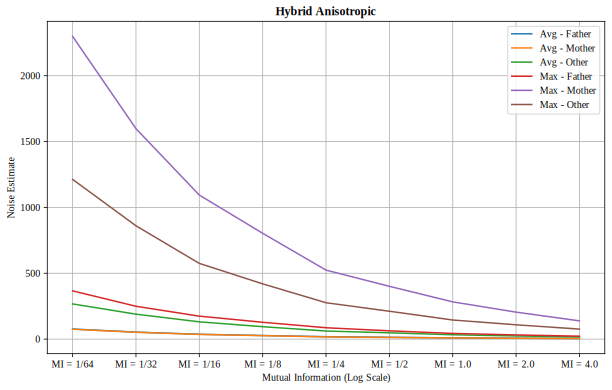

24/04/11 05:44:43 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 958195 ms exceeds timeout 120000 ms
24/04/11 05:44:44 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/11 06:02:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
color_labels = ['Avg - Father', 'Avg - Mother', 'Avg - Other', 'Max - Father', 'Max - Mother', 'Max - Other']
x_values = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(y_values.shape[1]):
    ax.plot(x_values, y_values[:, i], label=color_labels[i])
    
ax.set_xlabel('Mutual Information (Log Scale)')
ax.set_ylabel('Noise Estimate')
ax.set_title('Hybrid Anisotropic')
ax.set_xscale('log', base=2)
ax.set_xticks(x_values)
ax.set_xticklabels([f'MI = 1/{int(1/x_val)}' if x_val < 1 else f'MI = {x_val}' for x_val in x_values])
ax.legend()



# Show plot
plt.grid(True)
plt.savefig(f"figs/test_hybrid.png")

plt.show()


## Full Anisotropy

Conversion between dataframes and numpy vectors

In [25]:
from pyspark.sql.functions import max, avg
result = math_df.groupBy("guardian").agg(max("absences").alias("max_absences"), avg("absences").alias("avg_absences"))
result.show()

+--------+------------+-----------------+
|guardian|max_absences|     avg_absences|
+--------+------------+-----------------+
|  father|          21|3.977777777777778|
|  mother|          75|5.835164835164835|
|   other|          40|              9.5|
+--------+------------+-----------------+



In [11]:
from typing import Optional
import pyspark.sql.dataframe
import pyspark.sql.types as T
import pyspark.pandas as ps

df = math_df

def _unwrapDataFrame(df: pyspark.sql.DataFrame) -> np.ndarray:
    """
    Convert a PySpark DataFrame into a numpy vector.
    """
    
    numeric_columns: List[str] = [f.name for f in df.schema.fields if isinstance(f.dataType, T.NumericType)]
    df_numeric: pyspark.sql.DataFrame = df.select(*numeric_columns)  # select only numeric columns
    np_array: np.ndarray = np.array(df_numeric.collect())

    flat: np.ndarray = np_array.flatten(order="F")

    return flat

def _updateDataFrame(vec: np.ndarray, df: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """
    Use the values of the numpy vector to update the PySpark DataFrame.
    """

    numeric_columns: List[str] = [f.name for f in df.schema.fields if isinstance(f.dataType, T.NumericType)]
    df_numeric: pyspark.sql.DataFrame = df.select(*numeric_columns)  # select only numeric columns
    shape = np.array(df_numeric.collect()).shape

    np_array = vec.reshape(shape, order="F")
    new_pandas: ps.DataFrame = ps.DataFrame(np_array, columns=numeric_columns)
    print(new_pandas)

    old_pandas = df.pandas_api()
    old_pandas.update(new_pandas)

    return old_pandas.to_spark()


u1 = _unwrapDataFrame(df.filter(df["absences"] >= 5).agg(F.count("*")))
u2 = _unwrapDataFrame(df.groupBy(F.col("guardian")).agg(F.count("*")))
u3 = _unwrapDataFrame(df.groupBy(F.col("guardian")).agg(F.avg("absences"), F.max("absences")))

print(u1)
print(u2)
print(u3)

r1 = _updateDataFrame(u1, df.filter(df["absences"] >= 5).agg(F.count("*")))
r2 = _updateDataFrame(u2, df.groupBy(F.col("guardian")).agg(F.count("*")))
r3 = _updateDataFrame(u3, df.groupBy(F.col("guardian")).agg(F.avg("absences"), F.max("absences")))

r1.show()
r2.show()
r3.show()



[151]
[ 90 273  32]
[ 3.97777778  5.83516484  9.5        21.         75.         40.        ]


/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(series.dtype):


   count(1)
0       151


/opt/homebrew/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(series.dtype):


   count(1)
0        90
1       273
2        32


/opt/homebrew/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(series.dtype):


   avg(absences)  max(absences)
0       3.977778           21.0
1       5.835165           75.0
2       9.500000           40.0


/opt/homebrew/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


+--------+
|count(1)|
+--------+
|     151|
+--------+

+--------+--------+
|guardian|count(1)|
+--------+--------+
|  father|      90|
|  mother|     273|
|   other|      32|
+--------+--------+

+--------+-----------------+-------------+
|guardian|    avg(absences)|max(absences)|
+--------+-----------------+-------------+
|  father|3.977777777777778|         21.0|
|  mother|5.835164835164835|         75.0|
|   other|              9.5|         40.0|
+--------+-----------------+-------------+

